# SeSiMe
### Sentence/Sequence Similarity Measure

## This notebook:  In-depth comparison of spectrum-spectrum similarity scoring.

### 'Labeled data' is here: GNPS Dataset of 11134 spectra with smiles.

In [1]:
# data locations
ROOT = "C:\\OneDrive - Netherlands eScience Center\\Project_Wageningen_iOMEGA"
PATH_MS_DATA = ROOT + "\\Data\\labeled_MS_data\\"
PATH_SAVE_DATA = ROOT + "\\SeSiMe\\data\\"
PATH_SAVE_MODEL = ROOT + "\\SeSiMe\\models_trained\\"
PATH_SESIME = ROOT + "\\SeSiMe\\"

PATH_NPLINKER = ROOT + "\\nplinker\\prototype\\"
#mgf_file = PATH_MS_DATA + "GNPSLibraries_allSMILES.mgf"
mgf_file = PATH_MS_DATA + "GNPSLibraries_uniqueSMILES_withFeatureIDs.mgf"

In [2]:
# import general packages
import sys
sys.path.insert(0, PATH_NPLINKER)
sys.path.insert(0, PATH_SESIME)

import helper_functions as functions
import MS_functions

import numpy as np
from metabolomics import load_spectra

In [3]:
# Import / Load data
results_file = "filtered_data_unique_smiles_minpeak10_loss500_2dec.json"

spectra, spectra_dict, MS_documents, MS_documents_intensity, sub_spectra_metadata = MS_functions.load_MGF_data(PATH_SAVE_DATA,
                  mgf_file, 
                 results_file = results_file,
                 num_decimals = 2,
                 min_frag = 0.0, max_frag = 1000.0,
                 min_loss = 5.0, max_loss = 500.0,
                 min_intensity_perc = 0.01, #0
                 exp_intensity_filter = None, #0.01,
                 min_peaks = 10,
                 peaks_per_mz = 15/200,
                 peak_loss_words = ['peak_', 'loss_'], #['mz_', 'mz_'], 
                 sub_spectra = False)

Spectra json file found and loaded.


#### Switch to general SeSiMe functionality
Once we have a corpus (e.g. through cells above), we can use SeSiMe to apply different similarity measuring methds. 

In [4]:
from Similarities import SimilarityMeasures

MS_measure = SimilarityMeasures(MS_documents)

Using TensorFlow backend.


In [5]:
MS_measure.preprocess_documents(0.2, min_frequency = 2, create_stopwords = False)
print("Number of unique words: ", len(MS_measure.dictionary))

Preprocess documents...
Number of unique words:  67429


### Note
In total it would be about 100.000 words. Many occur only once in the entire corpus and are hence filtered out (makes not sense to place them somewhere in word-space, would be arbitrary!).

Few also are filtered out because they occur too often (in more than 20% of the spectra). Those words have little discriminative power and are hence ignored. Might still be worth keeping them in for comparison!

## Word2Vec -based approach
### 1) Model trained on unique smiles dataset only.

In [6]:
file_model_word2vec = PATH_SAVE_MODEL + 'model_w2v_MS_gnps_uniquesmiles_d300_w300_iter100_loss500_minpeak10_dec2.model'
MS_measure.build_model_word2vec(file_model_word2vec, size=300, window=300, 
                             min_count=1, workers=4, iter=100, 
                             use_stored_model=True)

Load stored word2vec model ...


In [7]:
# Use peak intensities as extra weights
MS_measure.get_vectors_centroid(method = 'update', #'ignore',
                             extra_weights = MS_documents_intensity, 
                             tfidf_weighted = True, 
                             weight_method = 'sqrt', 
                             tfidf_model = None,
                             extra_epochs = 5)

All 'words' of the given documents were found in the trained word2vec model.
No tfidf model found.
  Calculated centroid vectors for  9550  of  9550  documents.Calculated centroid vectors for  600  of  9550  documents.  of  9550  documents.9550  documents.3110  of  9550  documents. 9550  documents.4120  of  9550  documents.9550  documents. Calculated centroid vectors for  5870  of  9550  documents. 8420  of  9550  documents.

## Calculate/load the different score matrices
### all-vs-all matrix of spectrum-spectrum similarity scores
+ Word2Vec-centroid similarity scores
+ Cosine similarity scores
+ Modified cosine scores (MolNet)
+ Molecular similarity scores based on molecular fingerprints. Unless stated otherwise: Dice score based on morgen-3 fingerprints.

### Calculate/load modified cosine score (here using Hungarian algorithm)
+ Be aware: calculating those is **very slow** !
+ Function below will load the given file and only calculate the scores from scratch if no such file is found.

In [8]:
filename = PATH_SAVE_DATA + "MolNet_gnps_uniquesmiles_exp001_loss500_minpeak10_dec2_tol02_minmatch2_hungarian.npy"
molnet_sim_hung = MS_functions.molnet_matrix(spectra, 
                  tol = 0.2, 
                  max_mz = 1000, 
                  min_mz = 0, 
                  min_match = 2, 
                  min_intens = 0.01,
                  filename = filename)

Complete MolNet similarity scores found and loaded.


### Calculate/load cosine scores 
+ Calculating is much faster than the modified cosine score, but can still become **slow**, especially when using small tolerances and little filtering (resulting in many peaks...). 
+ Commented out for this notebook, so only loading...

In [9]:
#cosine_sim = MS_functions.cosine_matrix_fast(spectra,
#                                           tol = 0.1,
#                                           max_mz = 1000, 
#                                           min_mz = 0)

filename = PATH_SAVE_DATA + "cosine_gnps_uniquesmiles_exp001_loss500_minpeak10_dec2_tol01_minmatch1_minintens001_fast.npy"
cosine_sim = np.load(filename)

### Calculate/load molecular similarity scores
+ first calculate molecular fingerprints
+ then calculate (or load if file exists) molecular similarity scores.  

Method for calculating fingerprints here can be "morgan1", "morgan2", "morgan3" or "daylight". For morgan fingerprints scores will be based on Dice scores. For "daylight" fingerprint it will be Tanimoto scores. 

In [10]:
molecules, fingerprints_m3, exclude_IDs = MS_functions.get_mol_fingerprints(spectra_dict, method = "morgan3")
exclude = [np.where(np.array(sub_spectra_metadata)[:,1] == x)[0][0] for x in exclude_IDs]

Problem with molecule 7402
Could not be solved by using the InChikey.
Problem with molecule 7452
Could not be solved by using the InChikey.
Problem with molecule 7522
Could not be solved by using the InChikey.
Problem with molecule 7612
Could not be solved by using the InChikey.
Problem with molecule 13527
Could not be solved by using the InChikey.
Problem with molecule 13771
Could not be solved by using the InChikey.
Problem with molecule 14111
Could not be solved by using the InChikey.
Problem with molecule 14429
Could not be solved by using the InChikey.
Problem with molecule 14652
Could not be solved by using the InChikey.
Problem with molecule 15085
Could not be solved by using the InChikey.
Problem with molecule 15140
Could not be solved by using the InChikey.
Problem with molecule 15175
Could not be solved by using the InChikey.
Problem with molecule 15531
Could not be solved by using the InChikey.
Problem with molecule 15810
Could not be solved by using the InChikey.
Problem wi

In [11]:
filename = PATH_SAVE_DATA + "tanimoto_gnps_uniquesmiles_exp001_loss500_minpeak10_dec2_morgan3.npy"
molecular_similarities = MS_functions.tanimoto_matrix(spectra, 
                                                      fingerprints_m3,
                                                      filename = filename)

Molecular similarity scores found and loaded.


### Calculate all-vs-all matrix for Word2Vec scores 

In [12]:
from scipy import spatial
M_sim_ctr = 1 - spatial.distance.cdist(MS_measure.vectors_centroid, MS_measure.vectors_centroid, 'cosine')

### Query: select possible spectral pairs of interest!

### Example for: cosine=high, molnet=high, word2vec=low, molecular similarity=low

In [13]:
pair_selection = np.where((cosine_sim > 0.8)
                          & (molnet_sim_hung >  0.9)
                & (M_sim_ctr < 0.3)  
                & (molecular_similarities < 0.3))

print("Found ", pair_selection[0].shape, " matching spectral pairs.")

Found  (3108,)  matching spectral pairs.


182 3618
Word2Vec score:  0.06553146576171354
Cosine score:  0.9105011868162942
Modified cosine score:  0.9129365153263284
Molecular similarity:  0.1889763779527559
  Created documents for  2  of  2  spectra.

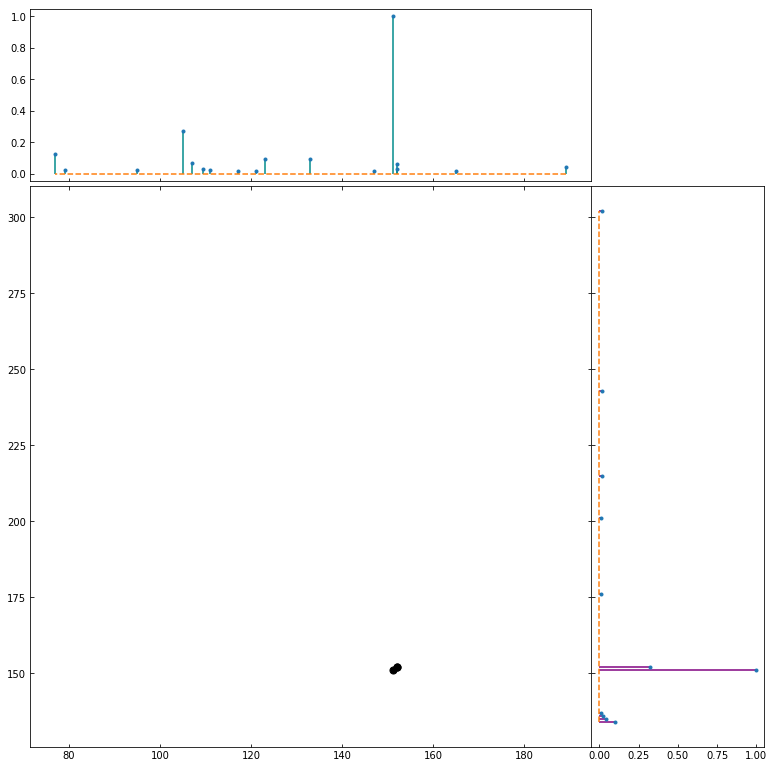

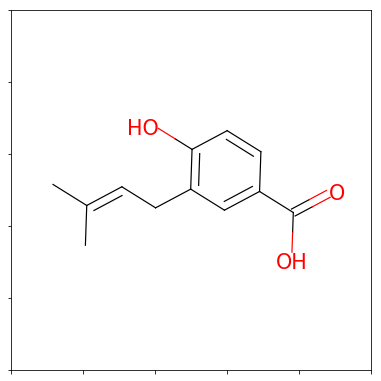

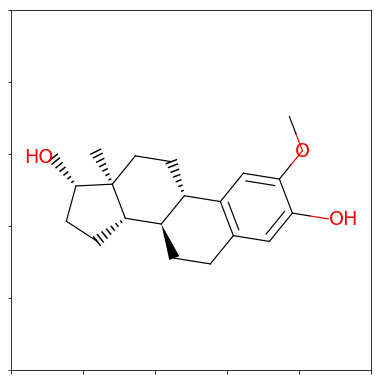

In [32]:
id = 70 #4, 6, 8, 60
ID1, ID2 = pair_selection[0][id], pair_selection[1][id]
print(ID1, ID2)
print("Word2Vec score: ", M_sim_ctr[ID1, ID2])
print("Cosine score: ", cosine_sim[ID1, ID2])
print("Modified cosine score: ", molnet_sim_hung[ID1, ID2])
print("Molecular similarity: ", molecular_similarities[ID1, ID2])

Csim_words = MS_functions.plot_spectra_comparison(MS_measure,
                                                  spectra,
                                                  2,
                                                  ID1, ID2, 
                                                  min_mz = 0, 
                                                  max_mz = 1000,
                                                  threshold = 0.001,
                                                  wordsim_cutoff = 0.5,
                                                  plot_molecules = True)


### Example for: cosine=low, molnet=low, word2vec=high, molecular similarity=high

In [34]:
pair_selection = np.where((cosine_sim < 0.3)
                          & (molnet_sim_hung < 0.3)
                & (M_sim_ctr > 0.85) 
                & (M_sim_ctr < 0.98) 
                & (molecular_similarities > 0.8))

print("Found ", pair_selection[0].shape, " matching spectral pairs.")

Found  (782,)  matching spectral pairs.


283 1309
Word2Vec score:  0.8614050936046339
Cosine score:  0.26921257019982525
Modified cosine score:  0.2931774115401047
Molecular similarity:  0.8673684210526316
  Created documents for  2  of  2  spectra.

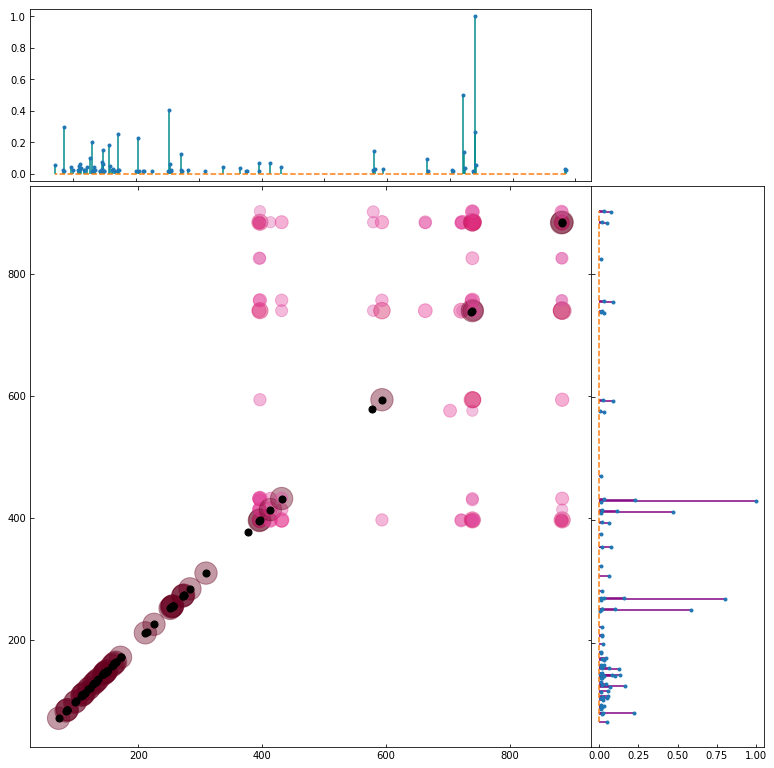

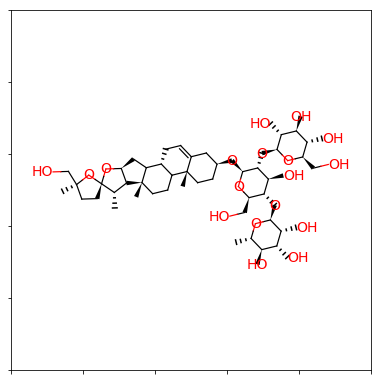

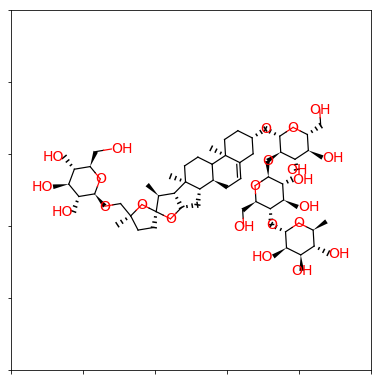

In [35]:
id = 0
ID1, ID2 = pair_selection[0][id], pair_selection[1][id]
print(ID1, ID2)
print("Word2Vec score: ", M_sim_ctr[ID1, ID2])
print("Cosine score: ", cosine_sim[ID1, ID2])
print("Modified cosine score: ", molnet_sim_hung[ID1, ID2])
print("Molecular similarity: ", molecular_similarities[ID1, ID2])

Csim_words = MS_functions.plot_spectra_comparison(MS_measure,
                                                  spectra,
                                                  2,
                                                  ID1, ID2, 
                                                  min_mz = 0, 
                                                  max_mz = 1000,
                                                  threshold = 0.001,
                                                  wordsim_cutoff = 0.5,
                                                  plot_molecules = True)

### Example for: cosine=low, molnet=high, word2vec=high, molecular similarity=high

In [36]:
pair_selection = np.where((cosine_sim < 0.3)
                          & (molnet_sim_hung > 0.9)
                & (M_sim_ctr > 0.85) 
                & (M_sim_ctr < 0.98) 
                & (molecular_similarities > 0.8))

print("Found ", pair_selection[0].shape, " matching spectral pairs.")

Found  (186,)  matching spectral pairs.


109 737
Word2Vec score:  0.8907677851511832
Cosine score:  0.10295443935639959
Modified cosine score:  0.931103924362519
Molecular similarity:  0.863905325443787
  Created documents for  2  of  2  spectra.

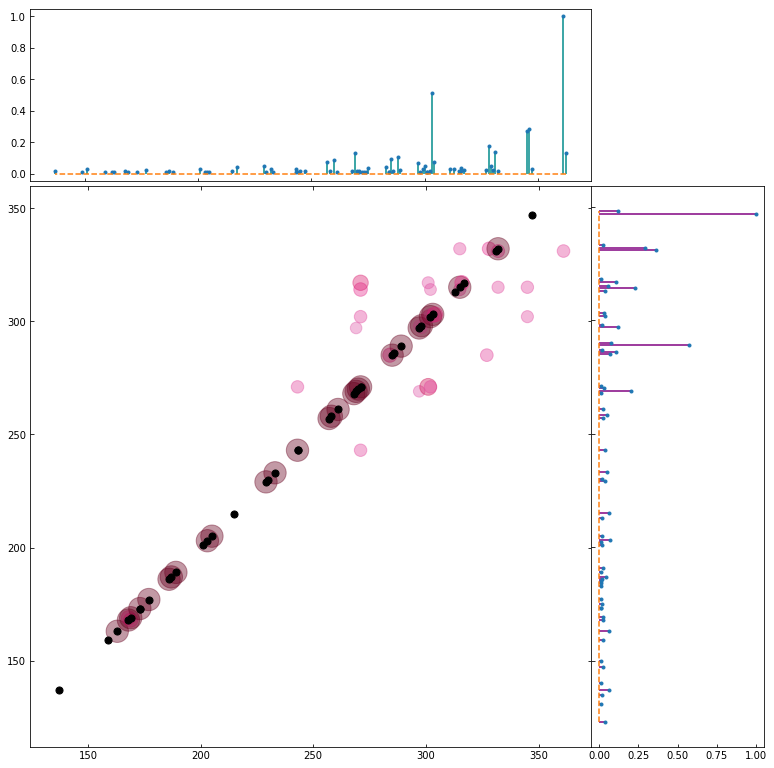

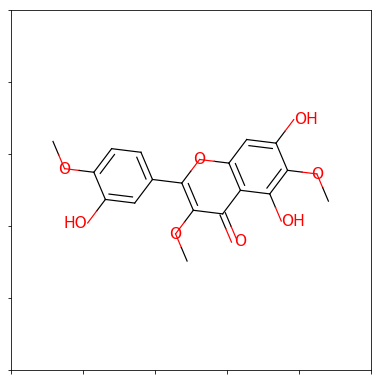

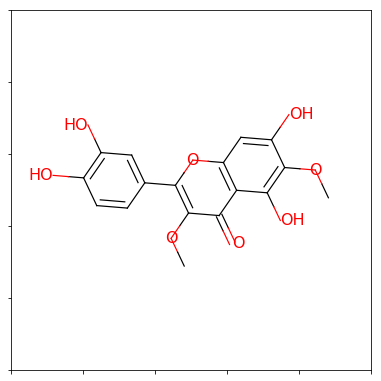

In [41]:
id = 0
ID1, ID2 = pair_selection[0][id], pair_selection[1][id]
print(ID1, ID2)
print("Word2Vec score: ", M_sim_ctr[ID1, ID2])
print("Cosine score: ", cosine_sim[ID1, ID2])
print("Modified cosine score: ", molnet_sim_hung[ID1, ID2])
print("Molecular similarity: ", molecular_similarities[ID1, ID2])

Csim_words = MS_functions.plot_spectra_comparison(MS_measure,
                                                  spectra,
                                                  2,
                                                  ID1, ID2, 
                                                  min_mz = 0, 
                                                  max_mz = 1000,
                                                  threshold = 0.001,
                                                  wordsim_cutoff = 0.5,
                                                  plot_molecules = True)

### Example for: cosine=high, molnet=high, word2vec=low, molecular similarity=high

In [55]:
pair_selection = np.where((cosine_sim > 0.8)
                          & (molnet_sim_hung > 0.9)
                & (M_sim_ctr < 0.4) 
                & (molecular_similarities > 0.8))

print("Found ", pair_selection[0].shape, " matching spectral pairs.")

Found  (8,)  matching spectral pairs.


3335 4830
Word2Vec score:  0.3937712626856361
Cosine score:  0.9833451754542634
Modified cosine score:  0.9778307683264843
Molecular similarity:  0.8136882129277566
  Created documents for  2  of  2  spectra.

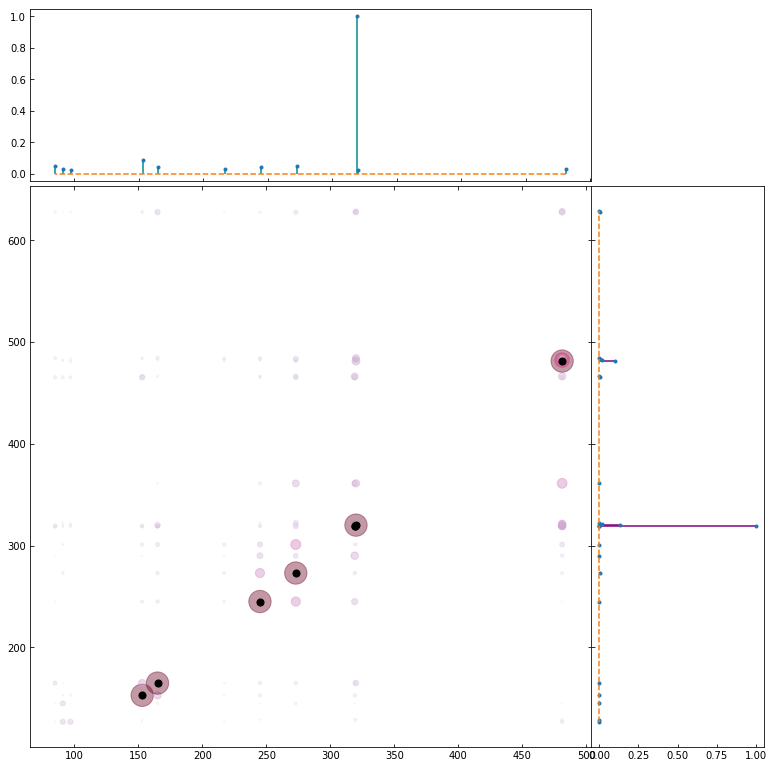

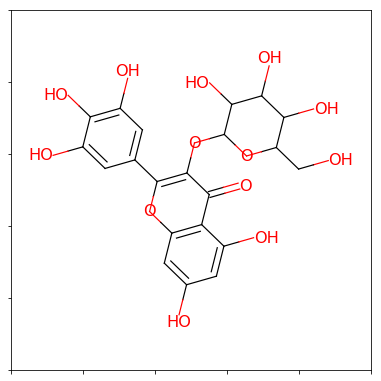

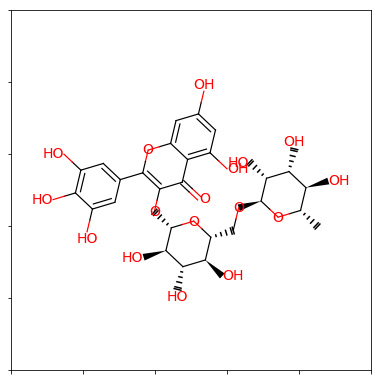

In [56]:
id = 1
ID1, ID2 = pair_selection[0][id], pair_selection[1][id]
print(ID1, ID2)
print("Word2Vec score: ", M_sim_ctr[ID1, ID2])
print("Cosine score: ", cosine_sim[ID1, ID2])
print("Modified cosine score: ", molnet_sim_hung[ID1, ID2])
print("Molecular similarity: ", molecular_similarities[ID1, ID2])

Csim_words = MS_functions.plot_spectra_comparison(MS_measure,
                                                  spectra,
                                                  2,
                                                  ID1, ID2, 
                                                  min_mz = 0, 
                                                  max_mz = 1000,
                                                  threshold = 0.001,
                                                  wordsim_cutoff = 0.0,
                                                  plot_molecules = True)